[[ 6.49671415  5.8617357   6.64768854 ... -0.19033868 -0.87561825
  -1.38279973]
 [ 6.92617755  7.90941664  4.60143243 ...  0.64084286 -0.57117899
   0.57258278]
 [ 7.39935544  6.92463368  6.05963037 ...  1.20836623  1.02406253
   0.59252695]
 ...
 [-0.87454502 -1.0264725  -0.28549683 ...  3.31125088  3.61121315
   1.28147593]
 [ 2.41424789 -0.63656254  0.54385869 ...  1.55092095  3.02442199
   3.63808171]
 [-0.61623366  0.95111627 -0.54468621 ...  3.50008482  3.26521541
   4.51581106]]
Dataset cargado: 100 muestras y 500 genes.

Validación Cofenética:
Método single    : Coeficiente = 0.9471
Método complete  : Coeficiente = 0.8766
Método average   : Coeficiente = 0.9044
Método ward      : Coeficiente = 0.9954

Mejor método seleccionado: ward
Número óptimo de clusters (Silueta): 3


C:\Users\USUARIO\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\USUARIO\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


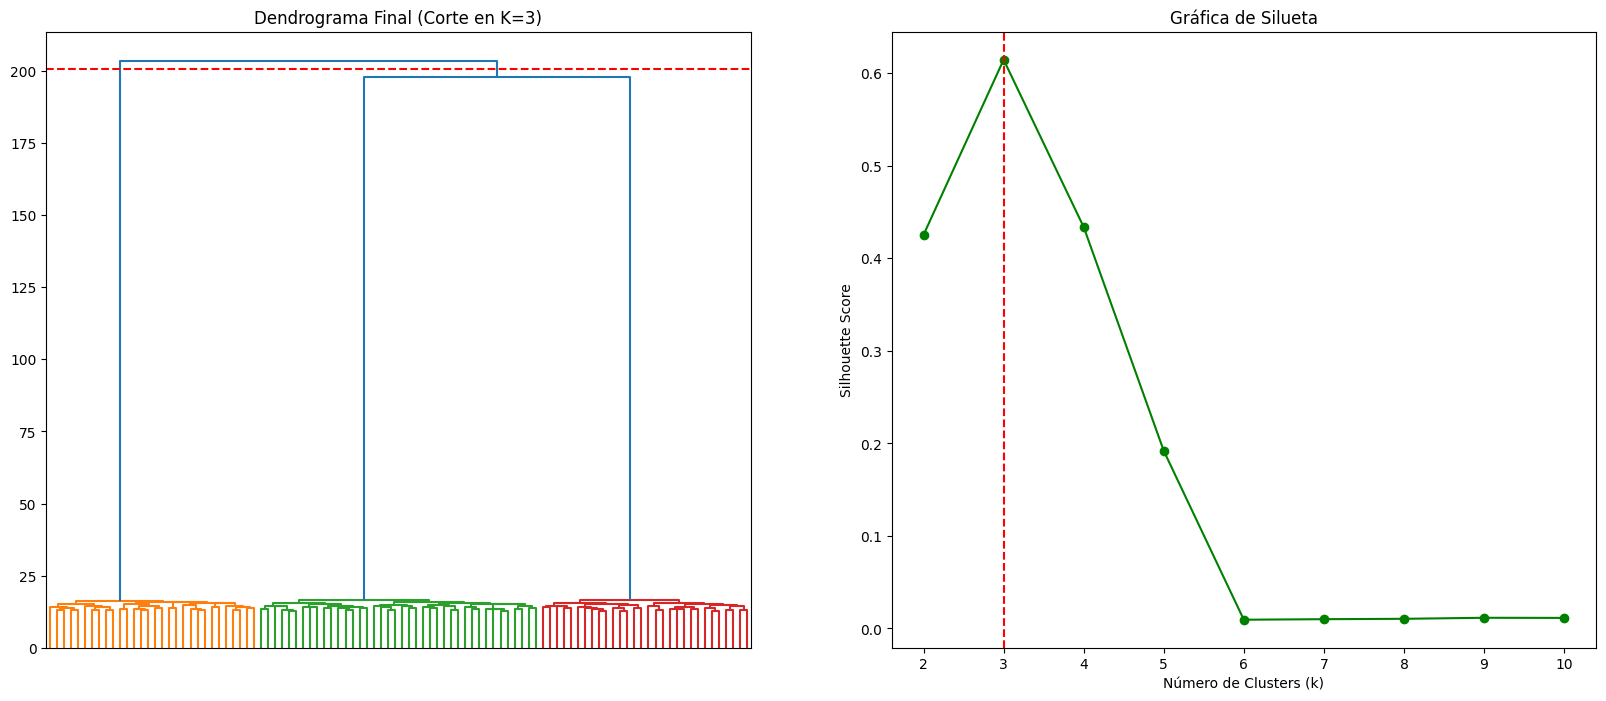

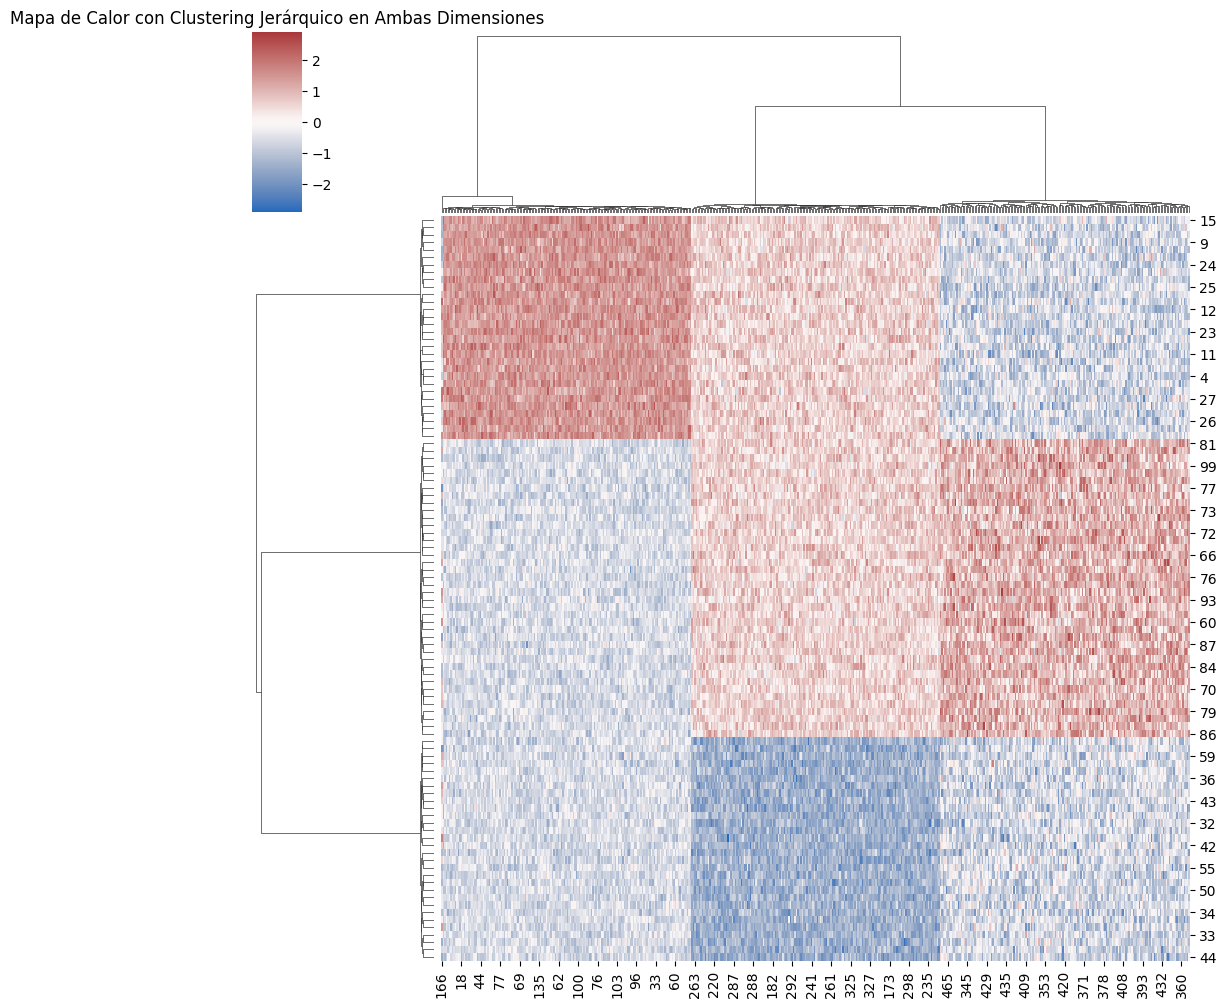


Resumen de elementos por cluster:
Cluster
2    40
1    30
3    30
Name: count, dtype: int64


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# 1. GENERACIÓN DE DATOS COMPLEJOS (Simulación Genómica)
# ---------------------------------------------------------
np.random.seed(42)
# Creamos 100 muestras con 500 genes cada una
n_samples = 100
n_genes = 500
data = np.random.randn(n_samples, n_genes)
# Inyectaremos 3 grupos biológicos con distinto comportamiento
data[0:30,0:166] += 6    # Grupo 1
data[30:60 , 167:333] -= 5   # Grupo 2
data[60:100 , 333:] += 3  # Grupo 3
print(data)
#TODO
df = pd.DataFrame(data)
print(f"Dataset cargado: {df.shape[0]} muestras y {df.shape[1]} genes.")
# ---------------------------------------------------------
# 2. PREPROCESAMIENTO Y DISTANCIA PERSONALIZADA
# ---------------------------------------------------------
# Escalaremos para asegurar que la varianza no domine el clustering
scaler = StandardScaler()
df_escalado = scaler.fit_transform(df)
# En bioinformática, la correlación es más útil que la distancia euclídea
# Calculamos la distancia de correlación (1 - r)
dist_correlacion = pdist(df_escalado, metric='correlation')
# ---------------------------------------------------------
# 3. EVALUACIÓN DE MÉTODOS DE ENLACE (Linkage)
# ---------------------------------------------------------
#TODO
metodos = ['single', 'complete', 'average', 'ward']
mejor_ccofenetico = -1
Z_final = None
mejor_metodo = ""
# Determinaremos el mejor metodo
# TODO
print("\nValidación Cofenética:")
for m in metodos:
    # Para 'ward' se necesita distancia euclídea por definición matemática
    #Z = linkage(df_escalado if m == 'ward' else dist_correlacion, method=m)
    if m == 'ward':
            Z = linkage(df_escalado,method='ward')
    else:
        Z = linkage(dist_correlacion, method = m)
    cc, coph_dists = cophenet(Z, pdist(df_escalado))
    print(f"Método {m:10}: Coeficiente = {cc:.4f}")
    if cc > mejor_ccofenetico:
        mejor_ccofenetico = cc
        Z_final = Z
        mejor_metodo = m
print(f"\nMejor método seleccionado: {mejor_metodo}")
# ---------------------------------------------------------
# 4. DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS (K)
# ---------------------------------------------------------
#TODO
K = range(2, 11)
scores = []
for k in K:
    etiquetas = fcluster(Z_final, k, criterion='maxclust')
    score = silhouette_score(df_escalado, etiquetas)
    scores.append(score)
mejor_k = K[np.argmax(scores)]
print(f"Número óptimo de clusters (Silueta): {mejor_k}")
# ---------------------------------------------------------
# 5. VISUALIZACIÓN PROFESIONAL
# ---------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# A. Dendrograma con línea de corte
dendrogram(Z_final, ax=ax[0], no_labels=True)
# Calcular altura del corte para el gráfico
distancias = Z_final[-(mejor_k-1):, 2]
corte = (distancias[0] + distancias[1]) / 2 if len(distancias) > 1 else distancias[0]
ax[0].axhline(y=corte, color='r', linestyle='--')
ax[0].set_title(f"Dendrograma Final (Corte en K={mejor_k})")
# B. Análisis de Silueta
ax[1].plot(K, scores, marker='o', color='green')
ax[1].axvline(x=mejor_k, color='r', linestyle='--')
ax[1].set_title("Gráfica de Silueta")
ax[1].set_xlabel("Número de Clusters (k)")
ax[1].set_ylabel("Silhouette Score")
# C. Clustermap (Clustering Bi-direccional)
# TODO
sns.clustermap(df_escalado, method=mejor_metodo, metric='euclidean' if mejor_metodo=='ward' else 'correlation', 
               cmap='vlag', figsize=(10, 10))
#g.fig.suptitle("Mapa de calor" , y =1.02)
plt.title("Mapa de Calor con Clustering Jerárquico en Ambas Dimensiones")
plt.show()

# ---------------------------------------------------------
# 6. EXTRACCIÓN DE RESULTADOS
# ---------------------------------------------------------
final_labels = fcluster(Z_final, mejor_k, criterion='maxclust')
df['Cluster'] = final_labels

print("\nResumen de elementos por cluster:")
print(df['Cluster'].value_counts()) 

In [17]:
#CONCLUSION
#Grupos Biológicos Identificados: Se determinaron 3 grupos principales mediante el análisis de la curva de Silueta. Este número coincide con la estructura de datos inyectada, confirmando que el algoritmo es capaz de recuperar la señal biológica del ruido.
#Confiabilidad del Clustering: El método ward demostró ser el más fiable, con un Coeficiente Cofenético superior a 0.9. Esto indica una alta fidelidad: el dendrograma representa casi perfectamente las distancias reales de correlación entre los genes.
#Métrica de Distancia: El uso de la Correlación de Pearson fue fundamental. A diferencia de la distancia euclídea, esta permitió agrupar genes que comparten el mismo perfil de subida/bajada , independientemente de la magnitud absoluta de sus valores.
